In [252]:
from torch import optim
import importlib, experiment
importlib.reload(experiment)
from experiment import Experiment
from copy import deepcopy
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

from optimizers import adamw, lion
importlib.reload(adamw)
importlib.reload(lion)
from optimizers.adamw import AdamW
from optimizers.lion import Lion

import matplotlib.pyplot as plt

Using device cpu


In [248]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_train = datasets.MNIST(root='/tmp/data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten())
]), train=True)
data_test = datasets.MNIST(root='/tmp/data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten())
]), train=False)

import numpy as np
np.random.seed(0)
from torch.utils.data import Subset

shuffle_idx = np.random.permutation(len(data_train.data))
data_train = Subset(data_train, shuffle_idx[:10000])

shuffle_idx = np.random.permutation(len(data_test.data))
data_test = Subset(data_test, shuffle_idx[:1000])

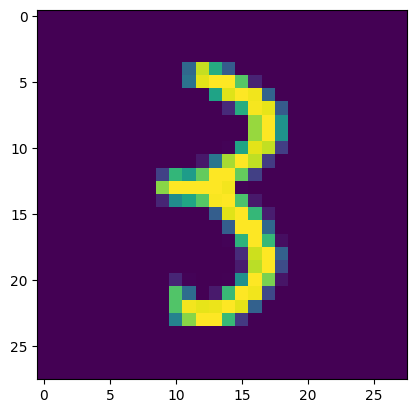

In [249]:
import matplotlib.pyplot as plt
plt.imshow(data_train[0][0].reshape(28, 28))

In [250]:
from torch import nn
simple_model = nn.Sequential(
    nn.Linear(28*28, 5),
    nn.ReLU(),
    nn.Linear(5, 10),
    nn.LogSoftmax(dim=1)
)

In [251]:
train_loader = DataLoader(data_train, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False)

In [253]:
optimizers = [optim.AdamW, AdamW]
experiments = []

for opt in optimizers:
    model_clone = deepcopy(simple_model)
    optimizer = opt(model_clone.parameters())
    experiment = Experiment(model_clone, train_loader, test_loader, optimizer, F.nll_loss,
                            metrics={'accuracy': accuracy_score}, mode="classification", name=opt.__name__)
    experiments.append(experiment)    

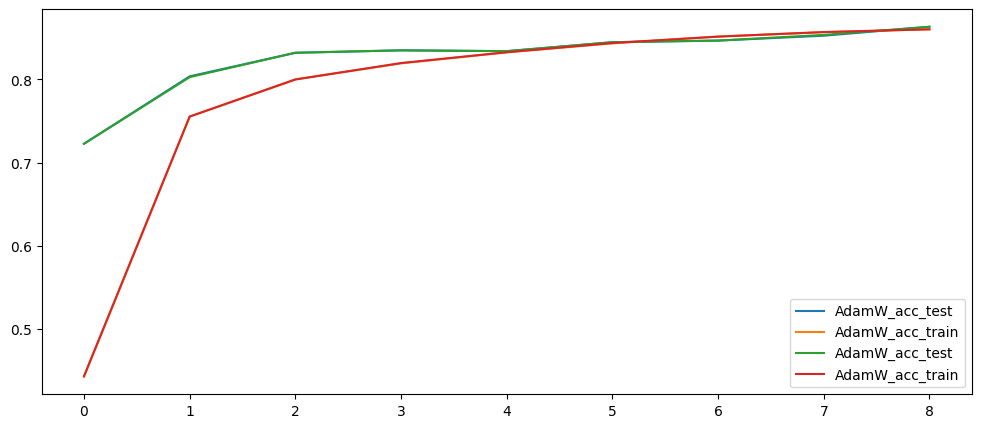

KeyboardInterrupt: 

In [255]:
from IPython.display import clear_output

for _ in range(100):
    for experiment in experiments:
        experiment.run(epochs=1, verbose=0)
    
    clear_output(True)
    plt.figure(figsize=(12, 5))
    for experiment in experiments:
        plt.plot(experiment.metrics_history['accuracy_test'][-20:], label=experiment.optimizer.__class__.__name__+"_acc_test")
        plt.plot(experiment.metrics_history['accuracy_train'][-20:], label=experiment.optimizer.__class__.__name__+"_acc_train")
    plt.legend()
    plt.show()
    

In [262]:
import torch

class TestFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([2., 1.]))
        
    def forward(self, *args, **kwargs):
        return 7*(self.x[0] - 10)**2 + (self.x[1]+5)**2
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

dummy_data = torch.tensor([[1, 1], [1, 1]])
model = TestFunction()
optimizer = AdamW(model.parameters(), lr=1, weight_decay=0, betas=(0.9, 0.999))
experiment = Experiment(model, dummy_data, None, optimizer, None, mode="function",  store_path=True)
experiment.run(epochs=100, verbose=0)
len(experiment.path)

100

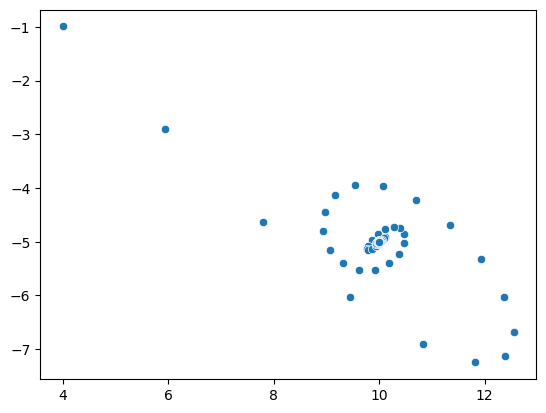

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns

x = [t[0][0] for t in experiment.path]
y = [t[0][1] for t in experiment.path]
sns.scatterplot(x=x, y=y)

plt.show()